In [2]:
# Imports de avisos
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulacao de dados e calculos matematicos
import os
import pandas as pd
import numpy as np
import math, re, time

# Import para manipulação das imagens
import matplotlib.pyplot as plt
from matplotlib import pyplot
import IPython.display as display
from PIL import Image
from skimage.transform import resize
import cv2

# Imports de bibliotecas para treinamento de redes neurais
import tensorflow as tf
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from keras.applications import VGG19, ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0


In [3]:
# Verifica qual o harware está usando (TPU, GPU ou CPU)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
#Carregando dataset de imagens de Flores¶
# Importando o dataset do storage do google
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# Verificando quantas imagens tem nos diretórios
image_count = len(list(data_dir.glob('*/*.jpg')))
print('Quantidade de Imagens: ', image_count)

# Verificando todas as classes de flores (licenciadas)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENCE.txt"])

# Removendo o item que não é uma classe
# Coloquei o indice 1 pois é onde está localizado o LICENCE.txt, mas pode ser que mude
# Se mudar, tem que corrigir o indice
CLASS_NAMES = np.delete(CLASS_NAMES, [1])

# Print das categorias de flores
print('Classes: ', CLASS_NAMES)

# Visualizando o tamanho de cada classe
fnames = []
for classes in CLASS_NAMES:
    flower_folder = os.path.join(data_dir, classes)
    file_names    = os.listdir(flower_folder)
    full_path     = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('Tamanho de cada classe de flor:', [len(f) for f in fnames])


Quantidade de Imagens:  3670
Classes:  ['daisy' 'sunflowers' 'roses' 'tulips' 'dandelion']
Tamanho de cada classe de flor: [633, 699, 641, 799, 898]


In [5]:
#Visualização dos Dados¶
tulips     = list(data_dir.glob('tulips/*'))
sunflowers = list(data_dir.glob('sunflowers/*'))
dandelion  = list(data_dir.glob('dandelion/*'))
roses      = list(data_dir.glob('roses/*'))
daisy      = list(data_dir.glob('daisy/*'))

(500, 333)


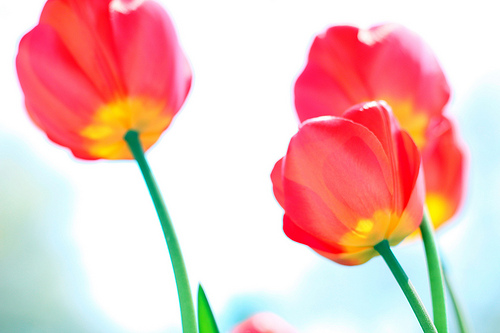

(500, 332)


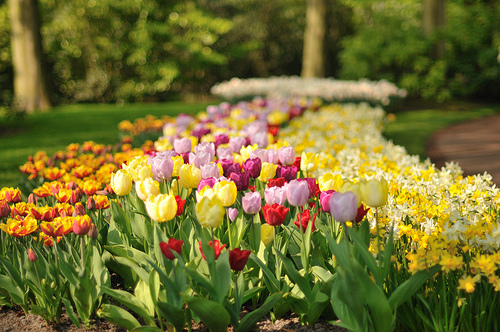

(320, 240)


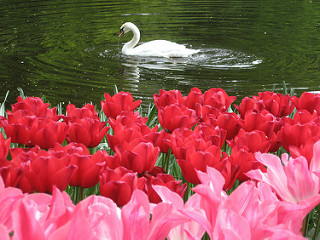

In [6]:
# Visualizando fotos de TULIPAS
for image_path in tulips[:3]:
  print(Image.open(str(image_path)).size)
  display.display(Image.open(str(image_path)))

(320, 264)


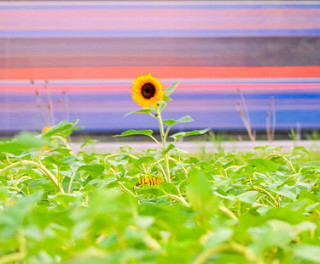

(500, 332)


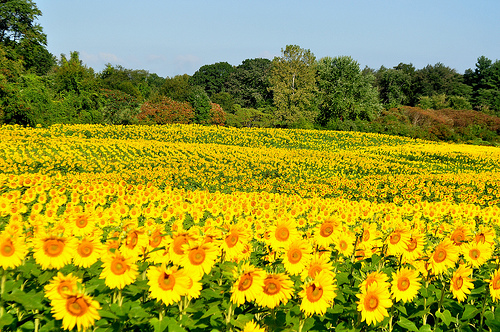

(500, 333)


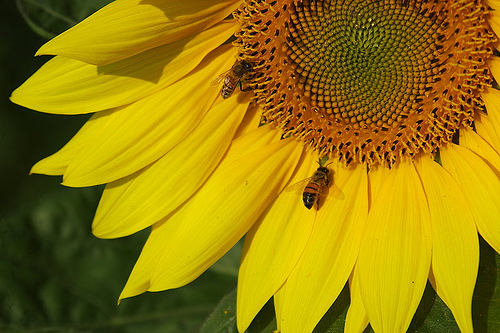

In [7]:
# Visualizando fotos de GIRASOL
for image_path in sunflowers[:3]:
  print(Image.open(str(image_path)).size)
  display.display(Image.open(str(image_path)))

In [8]:
# Carregando as imagens das fotos usando CV2
images = []
for names in fnames:
    one_class_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_class_images)

In [9]:

# Verificando qual o melhor shape para o redimensionamento de todas as fotos
for i,imgs in enumerate(images):
    shapes  = [img.shape for img in imgs]
    widths  = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d é o menor shape para %s' % (np.min(widths), np.min(heights), CLASS_NAMES[i]))



180,158 é o menor shape para daisy
180,152 é o menor shape para sunflowers
200,159 é o menor shape para roses
159,143 é o menor shape para tulips
211,146 é o menor shape para dandelion


In [10]:
# Função para converter as imagens para formato RGB
def convert_to_RGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)


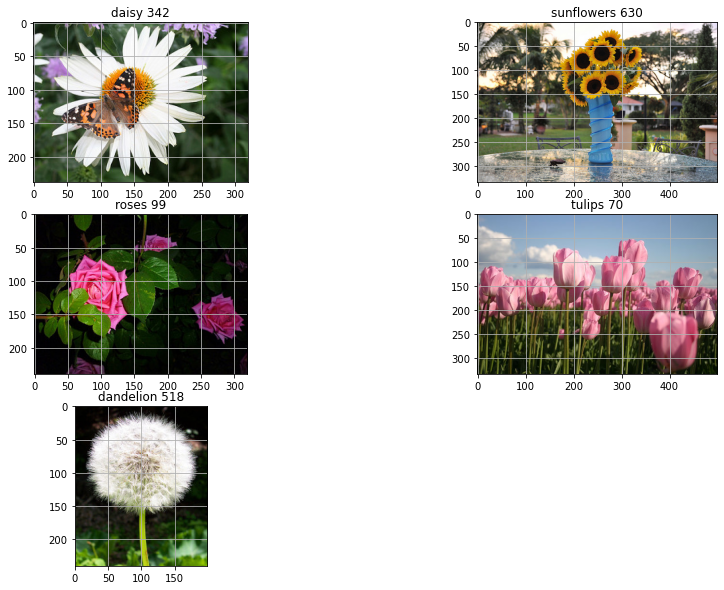

In [11]:
# Exibindo alguns exemplos das imagens convertidas para RGB
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(3,2,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(convert_to_RGB(imgs[idx]))
    plt.grid('off')
    plt.title(CLASS_NAMES[i]+' '+str(idx))
plt.show()



Shape Original:  (213, 320, 3)
Shape Alterado:  (256, 256, 3)


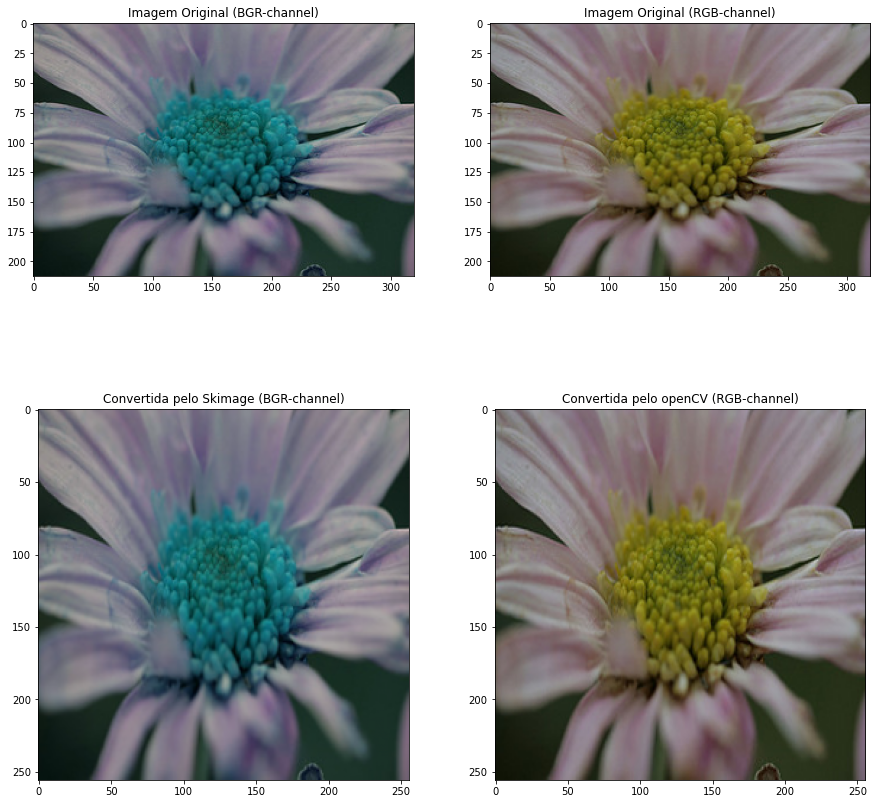

In [12]:
# Redimensionar todas as imagens para 256 x 256

# Definindo o tamanho do shape
img_width, img_height = 256, 256

# Pegando duas imagens de exemplo
img = images[0][2]

# Exibindo o shape original
print('Shape Original: ', img.shape)

# Redimensionando utilizando o skimage
resized_img = resize(img, (img_width, img_height, 3))
print('Shape Alterado: ', resized_img.shape)

# Redimensionando utilizando o openCV
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('Imagem Original (BGR-channel)')
plt.grid(False)
plt.imshow(img)

plt.subplot(2,2,2)
plt.title('Imagem Original (RGB-channel)')
plt.grid(False)
plt.imshow(convert_to_RGB(img))

plt.subplot(2,2,3)
plt.title('Convertida pelo Skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))

plt.subplot(2,2,4)
plt.title('Convertida pelo openCV (RGB-channel)')
plt.grid(False)
plt.imshow(convert_to_RGB(resized_img2))
plt.show()


In [13]:
# Redimensionando TODAS as imagens com o openCV
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

In [14]:
## Realizando o split dos dados para treinamento e validação (80/20)

# Criando as listas vazias
train_images = []
val_images   = []

# Loop percorrendo todaas as imagens redimensionadas e preenchendo as listas de treino e validação
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

In [15]:
## Criando os labels para as imagens de treinamento

# Exibindo a quantidade de dados para treinamento e a distribuição de cada classe
len_train_images = [len(imgs) for imgs in train_images]
print('Total para cada classe: ', len_train_images)
print('Total de imagens para treinamento:', np.sum(len_train_images))  

# Criando os labels de treinamento
train_classe = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_classe[:len_train_images[i]] = i
    else:
        train_classe[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i

Total para cada classe:  [506, 559, 512, 639, 718]
Total de imagens para treinamento: 2934


In [16]:
## Criando os labels para as imagens de validação

# Exibindo a quantidade de dados para validação e a distribuição de cada classe
len_val_images = [len(imgs) for imgs in val_images]
print('Total para cada classe: ', len_val_images)
print('Total de imagens para validação:', np.sum(len_val_images))  

# Criando os labels de validação
val_classe = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_classe[:len_val_images[i]] = i
    else:
        val_classe[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

Total para cada classe:  [127, 140, 129, 160, 180]
Total de imagens para validação: 736


In [17]:
## Convertendo as imagens em formato array do numpy para submeter ao treinamento

# Criando listas temporarias
tmp_train_imgs = []
tmp_val_imgs   = []

# Percorrendo o dataset de treinamento e adicionando na lista temporaria
for imgs in train_images:
    tmp_train_imgs += imgs

# Percorrendo o dataset de validação e adicionando na lista temporaria
for imgs in val_images:
    tmp_val_imgs += imgs

# Convertendo em formato array
train_images_np = np.array(tmp_train_imgs)
val_images_np   = np.array(tmp_val_imgs)

# Removendo listas temporarias
del tmp_train_imgs, tmp_val_imgs


In [18]:
print('*** Antes de converter***')
print('train data:', train_images_np.shape)
print('train labels:', train_classe.shape)

# Transformando os dados para o tipo float32
train_data   = train_images_np.astype('float32')
val_data     = val_images_np.astype('float32')

# Converter o array de labels para cada classe em vetores one-hot 
train_labels = np_utils.to_categorical(train_classe, len(CLASS_NAMES))
val_labels   = np_utils.to_categorical(val_classe, len(CLASS_NAMES))

print('\n*** Depois de converter ***')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

*** Antes de converter***
train data: (2934, 256, 256, 3)
train labels: (2934,)

*** Depois de converter ***
train data: (2934, 256, 256, 3)
train labels: (2934, 5)


In [19]:
# Definindo os parametros gerais para treinamento
batch_size = 16
epochs     = 50

In [20]:
# Função para criar a estrutura de nosso modelo CNN
def create_model_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=train_data.shape[1:], activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(CLASS_NAMES)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [21]:
# Função para criar a estrutura de nosso modelo usando como base o modelo pre-treinado VGG19
def create_model_VGG19():
    model = VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

    # Congelando as camadas que não seram treinadas (no caso as 5 primeiras)
    for layer in model.layers[:1]:
        layer.trainable = False

    # Adicionando nova camadas ao nosso modelo
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(len(CLASS_NAMES), activation="softmax")(x)

    # Criando o modelo final
    final_model = Model(inputs = model.input, outputs = predictions)
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return final_model

In [23]:
# Função para criar a estrutura de nosso modelo usando como base o modelo pre-treinado ResNet50
def create_model_ResNet50():

    model = Sequential()

    model.add(ResNet50(weights = "imagenet", include_top=False, pooling='avg'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(CLASS_NAMES), activation='softmax'))
    model.layers[0].trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [24]:
# Criando o modelo e verificando a estrutura
model_cnn = create_model_cnn()
model_cnn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0

In [25]:
model_VGG19 = create_model_VGG19()
model_VGG19.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [27]:

#Data Augmentation¶


## Aplicando data augmentation para melhorar a performance do modelo

# Para dataset de treinamento
train_datagen = ImageDataGenerator(rescale            = 1./255,
                                   rotation_range     = 40,
                                   width_shift_range  = 0.4,
                                   height_shift_range = 0.4,
                                   shear_range        = 0.2,
                                   zoom_range         = 0.3,
                                   horizontal_flip    = True)

# Para dataset de validação (apenas rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Fluxo em batch 32 usando train_datagen
train_generator = train_datagen.flow(train_data,
                                     train_labels,
                                     batch_size=batch_size)

val_generator = val_datagen.flow(val_data,
                                 val_labels,
                                 batch_size=batch_size)



In [ ]:

#Treinamento dos modelos
#Modelo Convolution Neural Network

# Marcando o tempo de início
start = time.time()

# Treinamento do modelo
# Realizando o treinamento do modelo CNN
history = model_cnn.fit_generator(generator        = train_generator, 
                                  steps_per_epoch  = len(train_data)/batch_size,
                                  epochs           = epochs, 
                                  validation_steps = len(val_data)/batch_size,
                                  validation_data  = val_generator, 
                                  verbose          = 2)

# Marcando o tempo final
end = time.time()
duration = end - start
print ('\n Modelo CNN - Duração %0.2f segundos (%0.1f minutos) para treinamento de %d epocas'%(duration, duration/60, epochs) )

Epoch 1/50
184/183 - 357s - loss: 1.6032 - acc: 0.2430 - val_loss: 1.5464 - val_acc: 0.2704
Epoch 2/50
184/183 - 347s - loss: 1.5979 - acc: 0.2474 - val_loss: 1.6005 - val_acc: 0.2459
Epoch 3/50
184/183 - 344s - loss: 1.6027 - acc: 0.2403 - val_loss: 1.5999 - val_acc: 0.2486
Epoch 4/50
184/183 - 341s - loss: 1.6010 - acc: 0.2461 - val_loss: 1.6015 - val_acc: 0.2418
Epoch 5/50
184/183 - 362s - loss: 1.6000 - acc: 0.2468 - val_loss: 1.5972 - val_acc: 0.2500
Epoch 6/50
184/183 - 342s - loss: 1.6024 - acc: 0.2389 - val_loss: 1.6012 - val_acc: 0.2446
Epoch 7/50
184/183 - 338s - loss: 1.6017 - acc: 0.2461 - val_loss: 1.6001 - val_acc: 0.2473
Epoch 8/50
184/183 - 334s - loss: 1.6009 - acc: 0.2410 - val_loss: 1.6007 - val_acc: 0.2405
Epoch 9/50
184/183 - 336s - loss: 1.6023 - acc: 0.2440 - val_loss: 1.5989 - val_acc: 0.2527
Epoch 10/50
184/183 - 340s - loss: 1.6003 - acc: 0.2454 - val_loss: 1.6020 - val_acc: 0.2364
Epoch 11/50


In [ ]:
# Marcando o tempo de início
start = time.time()

# Realizando o treinamento do modelo VGG19
history_vgg19 = model_VGG19.fit_generator(generator        = train_generator, 
                                          steps_per_epoch  = len(train_data)/batch_size,
                                          epochs           = epochs, 
                                          validation_steps = len(val_data)/batch_size,
                                          validation_data  = val_generator, 
                                          verbose          = 2)

# Marcando o tempo final
end = time.time()
duration = end - start
print ('\n Modelo VGG19 - Duração %0.2f seconds (%0.1f minutos) para treinamento de %d epocas'%(duration, duration/60, epochs) )

In [ ]:
#Modelo pré-treinado ResNet50¶
# Marcando o tempo de início
start = time.time()

# Realizando o treinamento do modelo ResNet50
history_resnet50 = model_ResNet50.fit_generator(generator        = train_generator, 
                                                steps_per_epoch  = len(train_data)/batch_size,
                                                epochs           = epochs, 
                                                validation_steps = len(val_data)/batch_size,
                                                validation_data  = val_generator, 
                                                verbose          = 2)

# Marcando o tempo final
end = time.time()
duration = end - start
print ('\n Modelo ResNet50 - Duração %0.2f segundos (%0.1f minutos) para treinamento de %d epocas'%(duration, duration/60, epochs) )

In [ ]:

#Validação do Modelo


# Função para exibir o desempenho do modelo em treino e teste
def plot_model(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Nro de Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Nro de Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()



In [ ]:
# Exibindo o desempenho do modelo
plot_model('Modelo CNN', history.history, epochs)

In [ ]:
# Função para realizar previsão da classe das imagens passadas como parâmetro
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)    

# Função para buscar a descrição do label
def desc_label(label):
  idx = np.where(label == 1)
  return idx[0][0]

In [ ]:
# Realizando as previsões e exibindo as imagens com os labels verdadeiros e previstos
print("***** Modelo CNN Treinado *****\n")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(700)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(convert_to_RGB(val_data.astype('uint8')[idx]))
  class_idx = desc_label(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], model_cnn)
  plt.title('True: %s || Pred: %s %d%%' % (CLASS_NAMES[class_idx], CLASS_NAMES[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()